In [65]:
database = "T:/Occurrence_Records/Quick1.sqlite"
outFile = "T:/Occurrence_Records/center1.shp"
mode = "points"
make_file = True

In [66]:
from datetime import datetime
import sqlite3
import pandas as pd
import geopandas as gpd
import random
from shapely.geometry import Point

timestamp = datetime.now()

# Get the record coordinates as a data frame
records = (pd.read_sql("""SELECT * FROM occurrence_records;""",
                       con=sqlite3.connect(database))
                       .astype({'decimalLongitude': 'float',
                               'decimalLatitude': 'float',
                               'radius_m': 'float'}))

# Make a point geometry from coordinates
gdf = gpd.GeoDataFrame(records,
                       geometry=gpd.points_from_xy(records['decimalLongitude'],
                                                   records['decimalLatitude']))

# Set the coordinate reference system
gdf.crs={'init' :'epsg:4326'}

# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<  POINTS
# If user just wants shapefile of given coordinates (point method)
if mode == "points":
    if make_file == True:
        # Simply save points
        gdf.to_file(outFile)

    out = gdf

# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<  FOOTPRINTS
# If the user wants to identify record footprints (point-radius or shape method)
if mode == "footprints":
    # Reproject record coordinates to facilitate buffering
    feetprints = gdf.to_crs(epsg=5070)

    # Use point-radius method
    feetprints['footprint'] = feetprints.apply(lambda x: x.geometry.buffer(x.radius_m), axis=1)
    feetprints.set_geometry(col='footprint', inplace=True, drop=True)

    # Overwrite when footprint WKT is provided (shape method; careful with projection) FORTHCOMING
    if list(gdf['footprintWKT'].unique()) != ['nan']:
        print("ALERT! footprintWKT was provided but not used.")

    if make_file == True:
        # Save results as shapefile
        feetprints.to_file(outFile)

    out = feetprints

# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<  RANDOM POINTS
# If the user wants a random point selected from within each footprint
if mode == "random":
    # Reproject record coordinates to facilitate buffering
    feetprints = gdf.to_crs(epsg=5070)
    
    # Use point-radius method
    feetprints['footprint'] = feetprints.apply(lambda x: x.geometry.buffer(x.radius_m), axis=1)
    feetprints.set_geometry(col='footprint', inplace=True, drop=True)

    # Overwrite when footprint WKT is provided (shape method; careful with projection) FORTHCOMING   
    if list(gdf['footprintWKT'].unique()) != ['nan']:
        print("ALERT! footprintWKT was provided but not used.")
        
    # Function to generate random points
    def generate_random(number, polygon):
        points = []
        minx, miny, maxx, maxy = polygon.bounds
        while len(points) < number:
            pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
            if polygon.contains(pnt):
                points.append(pnt)
        return points
    
    # Generate random points
    feetprints["random_points"] = feetprints["geometry"].apply(lambda x: generate_random(1, x)[0])
    feetprints.drop(["geometry"], axis=1, inplace=True)
    feetprints.set_geometry(col='random_points', inplace=True, drop=True)
    
    if make_file == True:
        # Save results as shapefile
        feetprints.to_file(outFile)
    
    out=feetprints
    
print("Exported shapefile: " + str(datetime.now() - timestamp))

In [70]:

import wrangler_functions as wf
gdf = wf.spatial_output(database, make_file, mode, output_file=outFile)

ModuleNotFoundError: No module named 'wrangler_functions'

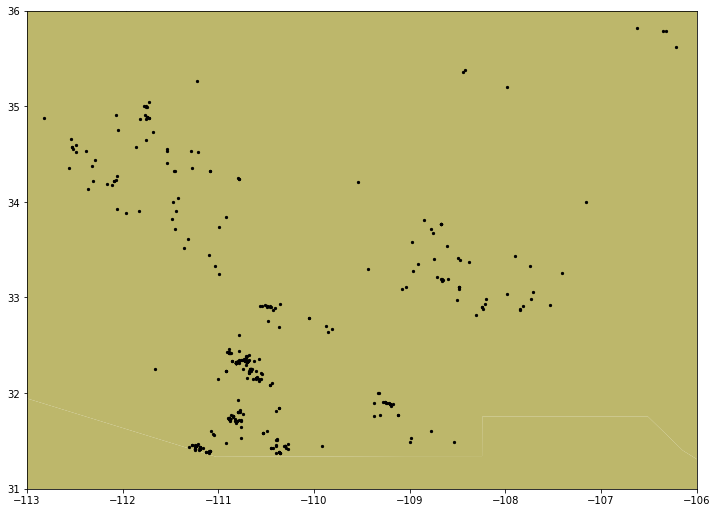

In [68]:
import numpy as np
import matplotlib.pyplot as plt

usa_bbox = np.array([-113.0,   31.0,  -106.0,   36.0])
fig, ax = plt.subplots(figsize=(12,12))
ax.set_xlim(([usa_bbox[0],  usa_bbox[2]]))
ax.set_ylim(([usa_bbox[1],  usa_bbox[3]]))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='darkkhaki')
gdf.plot(ax=ax, marker='o', color='k', markersize=5)
plt.show()